## Reference:
This file has been created referencing the following colab file (from class note):
 https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=wLHSIArLcFK0 


## Investigating the dataset
As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results 

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect.

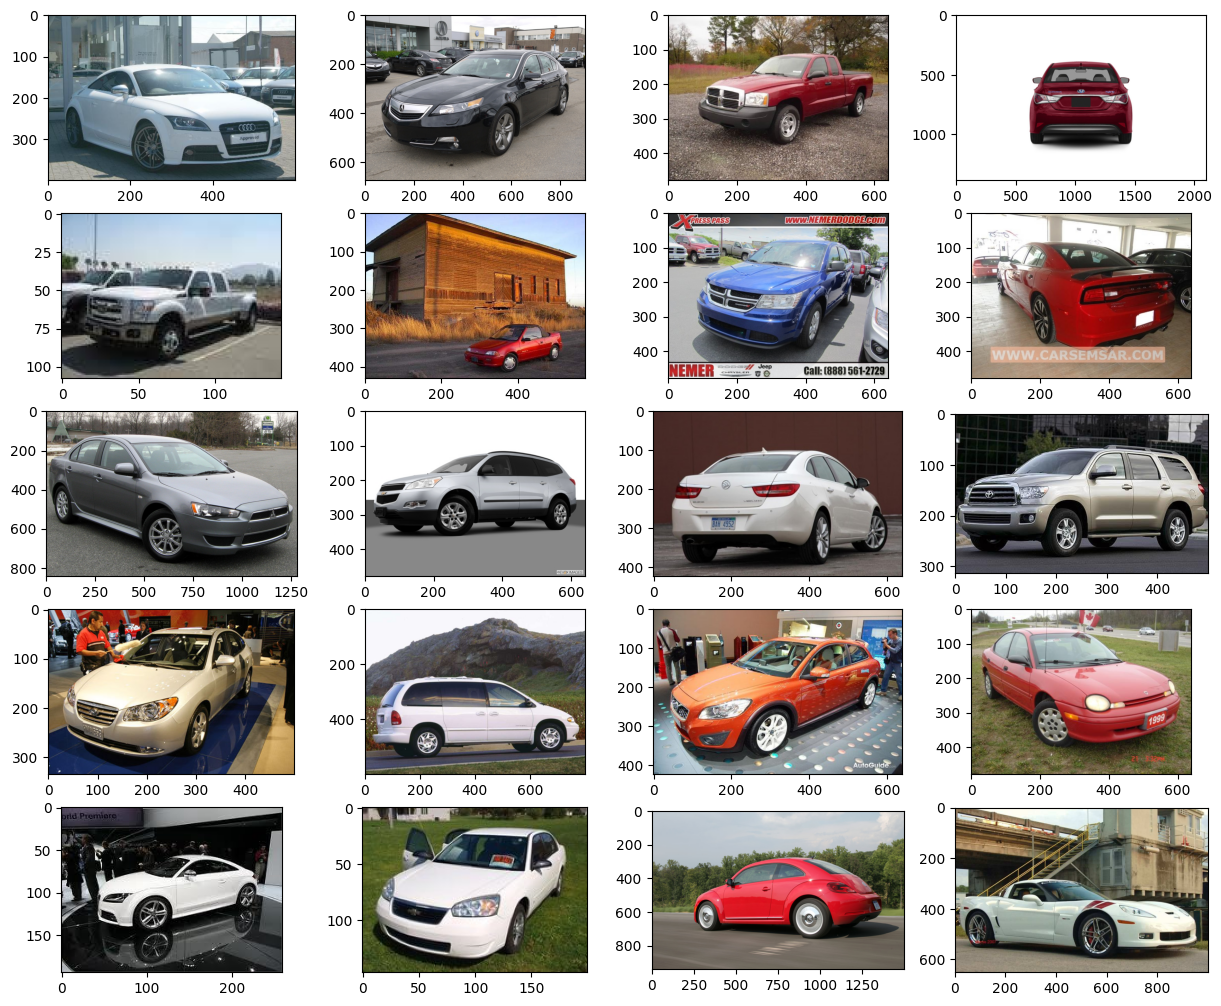

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])
path = '/Users/gitesh.grover/Study/data/Stanford-Cars-Dataset'
# Red - https://github.com/pytorch/vision/issues/7545#issuecomment-1631441616
data = torchvision.datasets.StanfordCars(root=path, download=False)
show_images(data)

# Building the Diffusion Model
## Step 1: The forward process = Noise scheduler

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways:**

The noise-levels/variances can be pre-computed
There are different types of variance schedules
We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
No model is needed in this forward step

In [14]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0) # Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1. 
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule i.e. create `T` equal steps on a line 
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas # 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [55]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),                           # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1)        # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    path = '/Users/gitesh.grover/Study/data/Stanford-Cars-Dataset'
    train = torchvision.datasets.StanfordCars(
        root=path, 
        download=False, 
        transform=data_transform
    )

    test = torchvision.datasets.StanfordCars(
        root=path, 
        download=False, 
        transform=data_transform, 
        split='test'
    )
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy()),    # Convert to NumPy explicitly
        transforms.Lambda(lambda t: (t * 255).astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_noise_images = 10
stepsize = int(T/num_noise_images)
print(f"T= {T} ;num_noise_images: {num_noise_images}; stepsize: {stepsize}")

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_noise_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

RuntimeError: Numpy is not available

In [45]:
import numpy as np
print("NumPy version:", np.__version__)
test_array = np.array([1, 2, 3])
print("Test array:", test_array)

NumPy version: 2.0.2
Test array: [1 2 3]
